## 2. Encoder-Decoder sobre imágenes
---
En la presente seccion se experimentará con arquitecturas del tipo *encoder-decoder* [[3]](#refs) aplicadas sobre imágenes, tales como *image translation*, *object location*, *image segmentation*, entre otros. La idea es aplicar una red convolucional en ambas partes del modelo (encoder y decoder), así utilizamos un modelo que se adapte a estos casos.

La tarea consistirá en realizar **Image Segmentation** [[4]](#refs) para identificar ciertos segmentos o regiones de interés en una imagen a través de procesar de manera semántica (en la codificación) si cada pixel corresponde a un segmento a destacar. Esta tarea puede ser aplicada tanto para identificar un segmento como para identificar múltiples segmentos a través de colocar varios canales/filtros de salida en el *decoder*. Para ésto trabajaremos con un dataset creado en el área (*A BENCHMARK FOR SEMANTIC IMAGE SEGMENTATION*). El dataset resulta bastante pequeño en cantidad de datos, por lo que deberá pensar en formas de conllevar ésto.

> a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos *versus* la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.

In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt

from PIL import Image as image


img_size = 100
data_dir = 'data/2'
filenames = [data_file.split('.')[0] for data_file in os.listdir(f'{data_dir}/image')]

X = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/image/{filename}.jpg')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])

Y = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/ground-truth/{filename}.png')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])

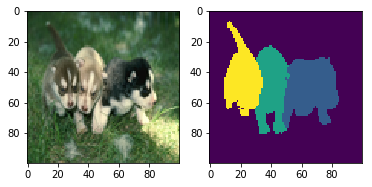

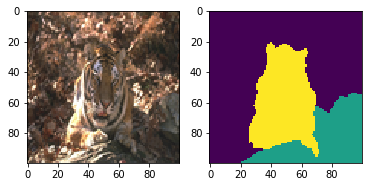

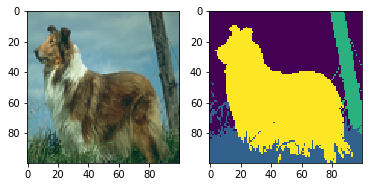

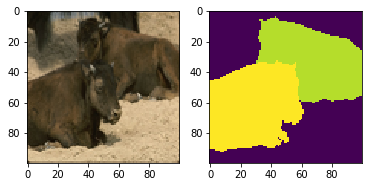

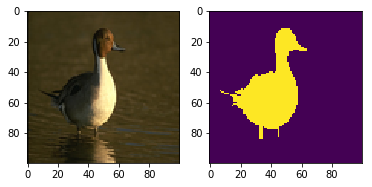

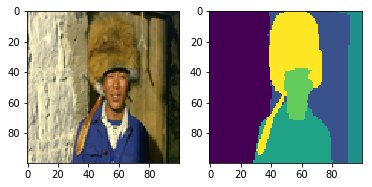

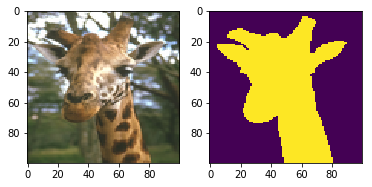

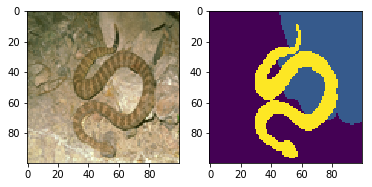

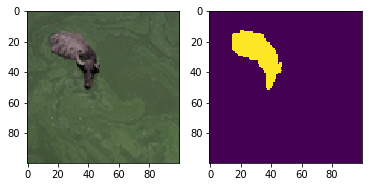

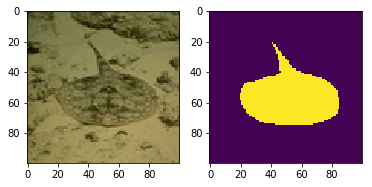

In [2]:
for i in range(10):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])

Se puede observar que el dataser consiste de un conjunto de imagenes asociadas a etiquetas (que también son imágenes) las cuales mapean cada pixel a un _sujeto_, diferenciandolo del fondo. Para cuando hay más de un sujeto, se tienen varios colores. Es decir, por cada sujeto se tiene un canal (con su respectivo color) el cual lo separa del fondo.

Se puede apreciar que el conjunto es bastante heterogéneo, es decir, las imágenes pertenecen a una ampla gama de temáticas.

Todas estas imágenes son escaladas a un tamaño de 80x80, dado que el dataset es pequeño y por inspección simple para ajustar los parámetros, encontramos que es un tamaño que permite entrenar en un tiempo razonable y que entrega mejores resultados que usarlas en su tamaño original, lo que obligaría a optimizar en un espacio de más dimensiones.

> b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.

Notar que separamos en entrenamiento y testeo. La separación del conjunto de validación será realizada durante el entrenamiento, usando los parámetros provistos por la API de keras.

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X, Y = X / 255., Y / 255.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10, random_state=42)

Using TensorFlow backend.


> c) Debido a la poca cantidad de datos presentes defina la arquitectura a utilizando únicamente convolucionales (*fully convolutional*) [[5]](#refs), como la presente en el código. Comente sobre los cambios en la dimensionalidad a través del *forward pass*. Decida el tamaño del *batch* en base a la cantidad de datos que se presenta para entrenar.

La red encoder aplica una convolucion sobre un kernel de 3x3. Cada dos capas se aplica max-pooling para reducir la dimensionalidad a la mitad en cada eje, lo cual permite aumentar la cantidad de canales usados en las siguientes dos capas.
Esto quiere decir, que se trata de mantener un numero relativcamente estable de parametros optimizables a lo largo de la capa, pero se intenta compensar la reducción en dimensionalidad del kernel usando una mayor cantidad de canales. En teoría son los canales los que se especializan en encontrar distintos objetos contrastados con el fondo, por lo que esta arquitectura debiese ser capaz de codificar bien los atributos de cada objeto.


Posteriormente se tienen las capas del decoder, las cuales realizan upsampling y reducen la cantidad de canales, hasta finalmente obtener algo que nuevamente se puede interpretar como una serie de canales que separan cada sujeto de la imagen del fondo.


Dado que se poseen pocos ejemplos de entrenamiento y estos son imagenes, es bueno tener un batch size relativamente pequeño, lo cual permite iterar más veces sobre un mismo epoch, sin tener en consideracion una gran cantidad de imagenes, que al ser muy heterogeneas podrían hacer de la convergencia de la red una tarea más difícil.

Se tiene que la función de pérdida es la binary crossentropy (la cual en teoria debiese ser capaz de modelar por cada pixel la probabilida de que sea sujeto o no), y como optimizador se usa Adam, que provee una convergencia en teoría más rápida para problemas donde se usa mini-batch.

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization

model = Sequential()
#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X.shape[1:]))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam')
h = model.fit(X_train, Y_train[:,:,:,None], epochs=100, batch_size=10, validation_data=(X_test, Y_test[:,:,:,None]))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv

90/90 [==============================] - 3s 36ms/step - loss: 0.4303 - val_loss: 0.5433
Epoch 58/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4349 - val_loss: 0.5747
Epoch 59/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4350 - val_loss: 0.5540
Epoch 60/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4288 - val_loss: 0.5550
Epoch 61/100
90/90 [==============================] - 3s 38ms/step - loss: 0.4171 - val_loss: 0.5652
Epoch 62/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4108 - val_loss: 0.5720
Epoch 63/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4125 - val_loss: 0.5735
Epoch 64/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4133 - val_loss: 0.6010
Epoch 65/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4098 - val_loss: 0.5502
Epoch 66/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4125 - val_loss: 0.5571
Epo

Notar que pasado una cierta cantidad de epochs la máquina comienza a memorizar los pocos ejemplos que hay y a ahcer overfitting sobre el conjunto de validación. Esto es atribuible a la poca cantidad de ejemplos existentes.

> d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza *versus* la segmentación real, además de verificar el *precision* y *recall* asumiendo valores binarios de pixel ¿Qué valor debería ser más importante los ceros o 1? Comente.

Se puede observar que la máquina es capaz de memorizar bastante bien las imágenes del conunto de entrenamiento, no así del conjunto de pruebas. Esto es atribuible principalmente a la falta de ejemplos disponibles, así como la dimensionalidad del problema. Esto a pesar de que la capa trata de mantener los parámetros a optimizar relativamente constantes a lo largo de la red.

Claramente, si el problema en el cual nos enfocamos es separar sujeto de fondo, es más importante contar con una buena precisión por sobre recall. Si nos enfocamos solo en obtener un buen recall, puede que la red sugiera que toda la imagen siempre es sujeto.

In [5]:
from sklearn.metrics import precision_score, recall_score

Y_train_label = Y_train.flatten() > 0.5
Y_test_label  = Y_test.flatten()  > 0.5

Y_hat_train_label = np.squeeze(model.predict(X_train)).flatten() > 0.5
Y_hat_test_label  = np.squeeze(model.predict(X_test)).flatten()  > 0.5

precision_train = precision_score(Y_train_label, Y_hat_train_label, average=None, labels=(0,1))
precision_test  = precision_score(Y_test_label, Y_hat_test_label, average=None, labels=(0,1))

recall_train = recall_score(Y_train_label, Y_hat_train_label, average=None, labels=(0,1))
recall_test  = recall_score(Y_test_label, Y_hat_test_label, average=None, labels=(0,1))

print('[TRAIN] Precision\t%s' % precision_train)
print('[TRAIN] Recall\t\t%s' % recall_train)

print('[TEST] Precision\t%s' % precision_test)
print('[TEST] Recall\t\t%s' % recall_test)

[TRAIN] Precision	[0.91036634 0.85999169]
[TRAIN] Recall		[0.93680678 0.80799849]
[TEST] Precision	[0.81424702 0.52352654]
[TEST] Recall		[0.77772565 0.5792171 ]


Notar que las imágenes generadas por la red no son buenas, pero si se aproximan a una versión desenfocada de la imagen original. Esto nos indica que estamos teniendo problemas cerca de los bordes de cada sujeto y que por lo tanto son aquellos los puntos donde nos debiesemos enfocar.

Es decir, se podría argumentar a favor del uso de una GAN, la cual debiese explotar la debilidad de esta máquina alrededor de los bordes de los objetos en la imágenes. Otra opción es realizar alguna transformacion sobre las imagenes de tal modo de entregar de forma mas clara a la red los lugares en donde existen bordes.

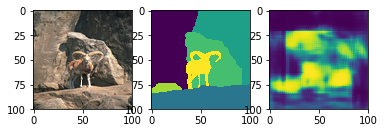

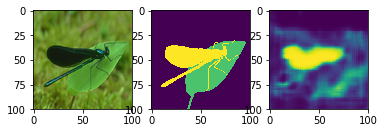

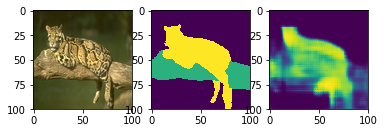

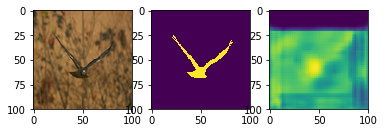

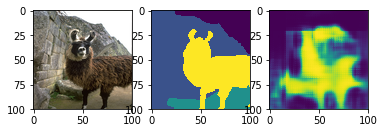

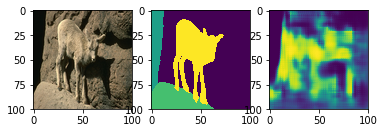

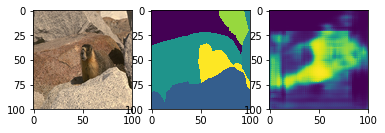

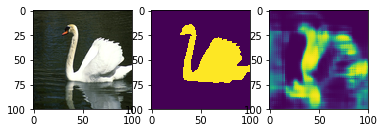

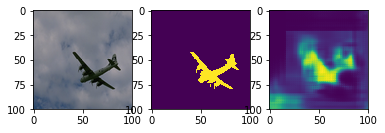

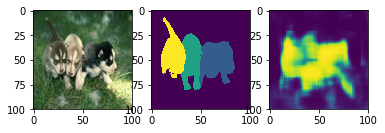

In [7]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X_test[i])
    ax[1].imshow(Y_test[i])
    ax[2].imshow(np.squeeze(model.predict(X_test[:i+1])[-1], axis=2))

> e) Compárese con alguna técnica manual de *Image Segmentation*, comúnmente se sugiere considerar un *treshold* para activar o apagar un píxel. Experimente con utilizar *treshold* igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en *skimage*.

En este caso lo que se realiza es segmentar manualmente la imagen usando una transformación, la cual no tiene parámetros realmente optimizables y no se puede entrenar.

A pesar de esto, podemos usar la técnica para modificar el input de la red y entrenarla con una versión segmentada de la imagen. Es decir, esto es equivalente a poner una capa que realiza una función determinista y que no es entrenable al principio de la red, la cual debiese transformar el input en algo que facilite a la red reconocer mejor los objetos presentes en la imagen.

In [8]:
from skimage import filters

X_gray = 0.333333 * X[:,:,:,0] + 0.333333 * X[:,:,:,1] + 0.333333 * X[:,:,:,2]
threshold_X = filters.threshold_otsu(X_gray)
mask_X = X_gray < threshold_X
X_segmented = mask_X * 1

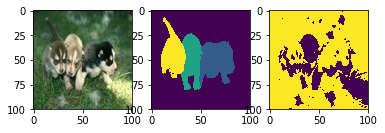

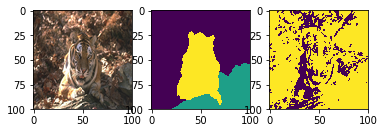

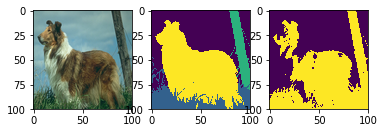

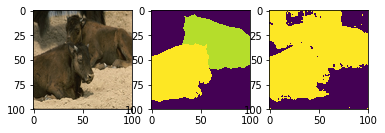

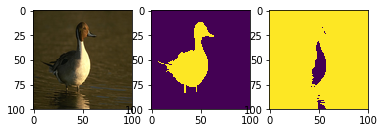

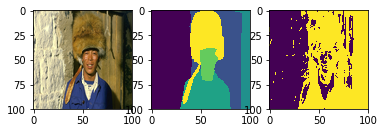

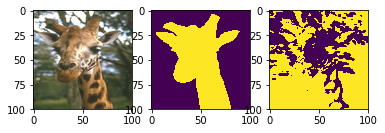

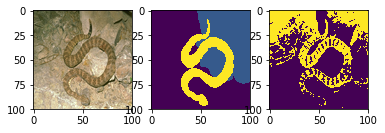

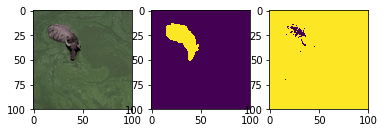

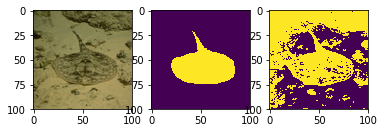

In [9]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(X[i])
    ax[1].imshow(Y[i])
    ax[2].imshow(X_segmented[i])

Como podemos apreciar, la segmentación no es perfecta, pero realiza una tranformación que convierte cada imagen que contiene una amplia gama de colores (256 de cada uno) en otra que contiene (equivalentemente) ceros y unos.

Así, procedemos a usar esta transformación como input de la red para probar su desempeño.

In [10]:
X_segmented = np.expand_dims(X_segmented, axis=3)
X_train_seg, X_test_seg, Y_train_seg, Y_test_seg = train_test_split(X_segmented, Y, test_size=10, random_state=42)

In [12]:
model = Sequential()
#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_train_seg[0].shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same')) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam')
h = model.fit(X_train_seg, Y_train_seg[:,:,:,None], epochs=100, batch_size=10, validation_data=(X_test_seg, Y_test_seg[:,:,:,None]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 25, 25, 128)       73856     
__________

Epoch 63/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4457 - val_loss: 0.5868
Epoch 64/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4446 - val_loss: 0.6341
Epoch 65/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4399 - val_loss: 0.6751
Epoch 66/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4488 - val_loss: 0.6096
Epoch 67/100
90/90 [==============================] - 3s 38ms/step - loss: 0.4386 - val_loss: 0.6573
Epoch 68/100
90/90 [==============================] - 3s 37ms/step - loss: 0.4178 - val_loss: 0.6899
Epoch 69/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4282 - val_loss: 0.6782
Epoch 70/100
90/90 [==============================] - 3s 36ms/step - loss: 0.4076 - val_loss: 0.6437
Epoch 71/100
90/90 [==============================] - 3s 36ms/step - loss: 0.3943 - val_loss: 0.7144
Epoch 72/100
90/90 [==============================] - 3s 36ms/step - loss: 0.3816 - val_los

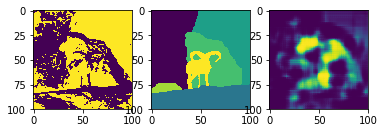

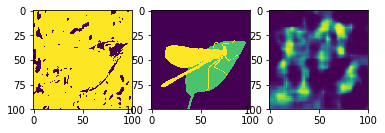

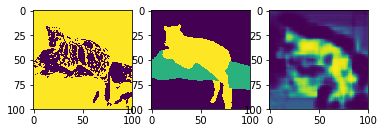

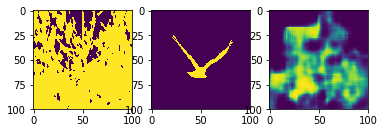

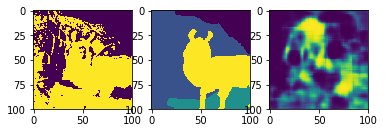

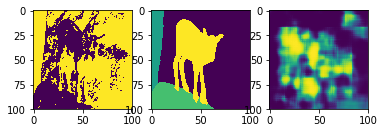

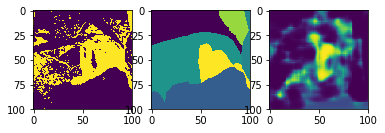

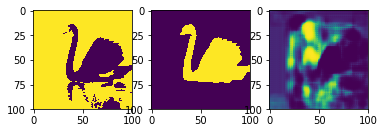

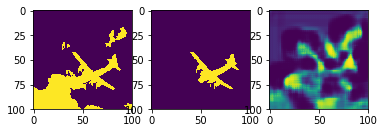

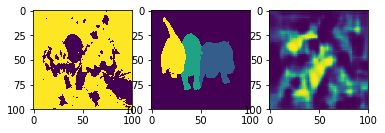

In [15]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(np.squeeze(X_test_seg[i]))
    ax[1].imshow(np.squeeze(Y_test_seg[i]))
    ax[2].imshow(np.squeeze(model.predict(X_test_seg[:i+1])[-1]))

In [16]:
Y_seg_train_label = Y_train_seg.flatten() > 0.5
Y_seg_test_label  = Y_test_seg.flatten()  > 0.5

Y_seg_hat_train_label = np.squeeze(model.predict(X_train_seg)).flatten() > 0.5
Y_seg_hat_test_label  = np.squeeze(model.predict(X_test_seg)).flatten()  > 0.5

precision_train = precision_score(Y_seg_train_label, Y_seg_hat_train_label, average=None, labels=(0,1))
precision_test  = precision_score(Y_seg_test_label, Y_seg_hat_test_label, average=None, labels=(0,1))

recall_train = recall_score(Y_seg_train_label, Y_seg_hat_train_label, average=None, labels=(0,1))
recall_test  = recall_score(Y_seg_test_label, Y_seg_hat_test_label, average=None, labels=(0,1))

print('[TRAIN] Precision\t%s' % precision_train)
print('[TRAIN] Recall\t\t%s' % recall_train)

print('[TEST] Precision\t%s' % precision_test)
print('[TEST] Recall\t\t%s' % recall_test)

[TRAIN] Precision	[0.87859451 0.94742217]
[TRAIN] Recall		[0.98086176 0.71786479]
[TEST] Precision	[0.74242827 0.44347039]
[TEST] Recall		[0.83393753 0.31383391]


Notar que si bien la loss, para los conjuntos de entrenamiento tanto como validación son similares en un inicio a los de la red entrenada sin la transformación previa, el resultado en términos de precisión y recall son peores, así como las imágenes generadas. Estas son de peor calidad, dado que visualmente no separan el fondo tan bien del sujeto.

Por otro lado, una vez se empieza a tener overfitting, este se dispara. Esto es atribuible a la gran perdida de información que conlleva realizar la transformación inicial de los datos de entrenamiento.

> f) Experimente con realizar *data augmentation* sobre el problema. Debido a que las operaciones clásicas de *augmentation* como rotar, invertir, girar, cambiarian la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida $Y$. Se presenta un código de ejemplo, *Denoising*, de aplicar una máscara binaria aleatoria sobre la imagen de entrada $X$, **de todas formas se espera que proponga alguna distinta**. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).

En este caso, lo que decidimos hacer es utilizar un generador. Es ideal para un problema para este, el cual tiene pocos ejemplos de entrenamiento.
La idea es generar de forma iterativa nuevos ejemplos de entrenamiento y etiquetas que salen de aplicar la misma perturbación aleatoria a ambos. Para cada minibatch se obtienen nuevos ejemplos.

Las tranformaciones que consideramos son rotaciones, desplazamientos en x e y, flips horizontales y verticales. Esto se hace tanto para el conjunto de entrenamiento como para las etiquetas.


Realizar esto genera nuevos ejemplos de entrenamiento, pero que son en cierto modo equivalentes a los anteriores, lo cual produce un overfitting que crece sin límites (la Loss diverge). Por este motivo realizaremos regularización sobre nuestra vesión que usa data augmentation.

> g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene.

Dado la mala performance ontenido en el ítem anterior, se realizará el mismo procedimiento, pero se aplicará regularización sobre la red.

Para esto usamos los mismos regularizadores, pero intentamos impedir que la red memorice los ejemplos de entrenamiento agregando capas especiales a la red. Para evitar la memorización aplicamos una capa de ruido gaussiano (muy sutil) al inicio del encoder. Por otro lado, creamos múlpliples capas de dropout, así como regularizamos usando norma L1 las capas finales de encoder y decoder.

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import sobel

generator_args = dict(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

X = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/image/{filename}.jpg')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])

Y = np.asarray([
    np.asarray(
        image.open(f'{data_dir}/ground-truth/{filename}.png')
            .resize((img_size, img_size), image.ANTIALIAS),
        dtype=np.uint8
    )
    for filename in filenames
])
X, Y = X / 255., Y / 255.

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=10, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=10, random_state=42)

generator_x = ImageDataGenerator(**generator_args)
generator_y = ImageDataGenerator(**generator_args)

seed = 42
generator_x.fit(X_train, seed=seed)
generator_y.fit(Y_train[:,:,:,None], seed=seed)

in_generator = generator_x.flow(X_train, seed=seed, batch_size=10)
out_generator = generator_y.flow(Y_train[:,:,:,None], seed=seed, batch_size=10)

train_generator = zip(in_generator, out_generator)

In [18]:
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout, GaussianNoise

model = Sequential()
#ENCODER PART
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=X_train[0].shape))
model.add(GaussianNoise(0.001))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(), bias_regularizer=l1()))
#DECODER PART
model.add(UpSampling2D((2, 2)))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same', kernel_regularizer=l1(), bias_regularizer=l1())) #pixel-wise classification
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 50, 50, 64)        18496     
___________________________

In [19]:
model.fit_generator(train_generator, steps_per_epoch=len(X_train), epochs=10, validation_data=(X_val, Y_val[:,:,:,None]))

Epoch 1/10
80/80 [==============================] - 34s 431ms/step - loss: 9.9522 - val_loss: 1.0147
Epoch 2/10
80/80 [==============================] - 33s 418ms/step - loss: 0.8655 - val_loss: 0.8028
Epoch 3/10
80/80 [==============================] - 33s 418ms/step - loss: 0.7808 - val_loss: 0.8012
Epoch 4/10
80/80 [==============================] - 33s 417ms/step - loss: 0.7655 - val_loss: 0.7412
Epoch 5/10
80/80 [==============================] - 35s 434ms/step - loss: 0.7453 - val_loss: 0.7312
Epoch 6/10
80/80 [==============================] - 33s 416ms/step - loss: 0.7434 - val_loss: 0.7416
Epoch 7/10
80/80 [==============================] - 33s 407ms/step - loss: 0.7406 - val_loss: 0.7390
Epoch 8/10
80/80 [==============================] - 33s 409ms/step - loss: 0.7329 - val_loss: 0.7606
Epoch 9/10
80/80 [==============================] - 33s 408ms/step - loss: 0.7335 - val_loss: 0.7096
Epoch 10/10
80/80 [==============================] - 33s 407ms/step - loss: 0.7235 - val_lo

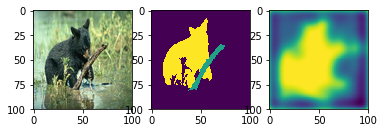

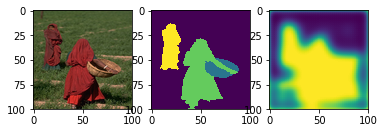

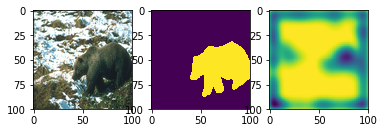

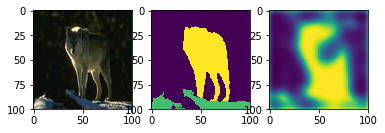

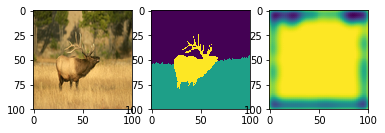

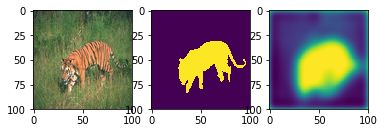

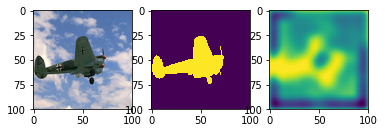

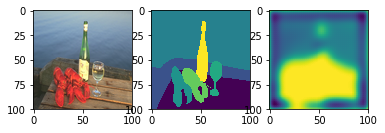

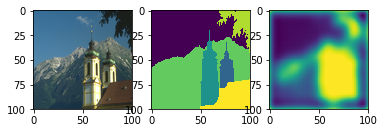

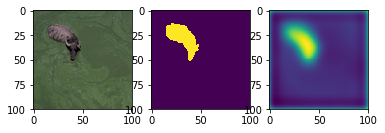

In [20]:
for i in range(10):
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(np.squeeze(X_test[i]))
    ax[1].imshow(np.squeeze(Y_test[i]))
    ax[2].imshow(np.squeeze(model.predict(X_test[:i+1])[-1]))

Así, obtenemos una red que no memoriza los ejemplos de entrenamiento. Es decir, logramos controlar el overfitting.

Sin embargo, hay un precio que se debe pagar por esto, y es que la red ya no es capaz de alcanzar un valor tan pequeño para la función de pérdida como lo hacía antes. En contraste, es capaz de generalizar mejor, encontrando resultados que no son tan buenos, pero que al ser analizados cualitativamente, pueden ser interpretados como una nube donde es más probable que haya objetos que no son fondo.